1. Suppose a truck arrives at a charging station and all C chargers are in use. Assume that all trucks take 4h to charge and the truck charging process follows Poisson statistics (i.e. the probability of an individual charger freeing up over any given time period is independent both of when other chargers freed up and when the truck arrived at the station). What's the average time the truck waits for a charger as a function of the number of chargers?

The probability p(t) that a given charger frees up over an infinitesimal time period follows a uniform distribution: 

Therefore, the probability P(t) that a given charger is still in use after time t is given by:

$$P(t) = \begin{cases}
 1-\frac{t}{\text{4h}}&\text{for $t\leq4$h}\\
0 &\text{for $t>4$h}
\end{cases}$$

$$P(t) = 1-\frac{t}{\text{4h}}$$

The probability that we're still waiting for a charger after time t is given by:

$$P_C(t) = \begin{cases}
 \Big(1-\frac{t}{\text{4h}}\Big)^C&\text{for $t\leq4$h}\\
0 &\text{for $t>4$h}
\end{cases}$$

The average wait time is given by:

$$\mu_C = \int_0^\text{4h}tP_C(t)dt$$

which can be evaluated numerically.

Text(0.5, 0, 'Number of chargers')

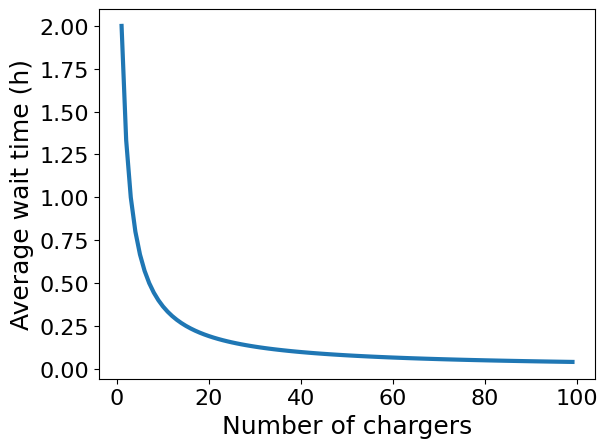

In [3]:
from scipy.integrate import quad
import numpy as np

ts = np.linspace(0, 4, 1000)

average_ts = []
Cs = np.arange(1,100)
for C in Cs:
    def P(t):
        return (1-t/4.)**C
    average_t, res = quad(P, 0, 4)
    average_ts.append(average_t)

import matplotlib.pyplot as plt

plt.plot(Cs, average_ts, '-', linewidth=3)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Average wait time (h)', fontsize=18)
plt.xlabel('Number of chargers', fontsize=18)

2. Now suppose there's a queue of Q other trucks waiting to charge. How does the average wait time vary as a function of C and Q?

If there's one truck in the queue, the newly arrived truck will need to wait $\mu_t$ on average for the truck ahead to start charging. The average wait time will then be:

$$\mu(Q=1) = \mu(Q=0) + \int_{\mu(Q=0)}^\text{4h}tP_{C-1}(t)dt$$

In general,

If Q $\leq$ C:

$$\mu(Q) = \sum_{i=1}^Q \Big[\mu(i-1) + \int_{\mu(i-1)}^\text{4h}tP_{C-i}(t)dt \Big]$$

If Q > C:

Let F = floor(Q/C) and R = Q - FC

$$\mu(Q) = \mu(R) + 4h \cdot F$$

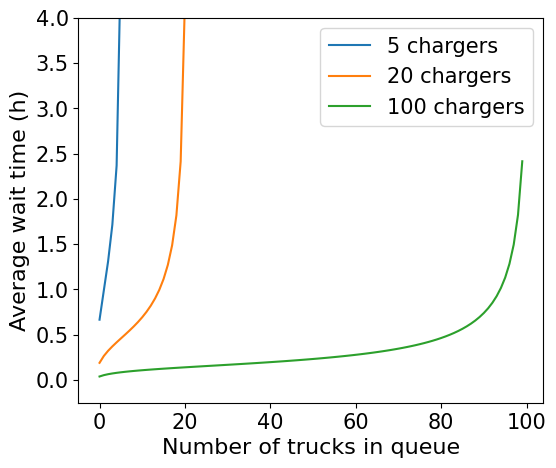

In [20]:
from scipy.integrate import quad
import numpy as np
ts = np.linspace(0, 4, 1000)

CHARGING_TIME=4.    # Charging time, in hours

Cs = [5, 20, 100]

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel('Number of trucks in queue', fontsize=16)
ax.set_ylabel('Average wait time (h)', fontsize=16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

# Average wait time for Q <= C
def mu_lt_C(Q, C):
    
    def P_C(t):
        return (1-t/CHARGING_TIME)**C
    
    mu_0, res = quad(P_C, 0, CHARGING_TIME)
    mu_last = mu_0
    mu_Q = mu_0
    for i in range(1, Q+1):  
        def P_C_minus_i(t):
            return (1-t/CHARGING_TIME)**(C-i)
        mu_Q_int, res = quad(P_C_minus_i, mu_last, CHARGING_TIME)
        mu_Q = mu_last + mu_Q_int
        mu_last = mu_Q 
    return mu_Q

# Average wait time in general (Q can be > C)
def mu(Q, C):
    if Q < C:
        return mu_lt_C(Q,C)
    else:
        F = np.floor(Q/C)
        R = int(Q - F*C)
        return mu_lt_C(R, C) + CHARGING_TIME*F

for C in Cs:
    mu_Qs = []
    Qs = np.arange(0, 100)
    for Q in Qs:
        mu_Qs.append(mu(Q, C))
    ax.plot(Qs, mu_Qs, label='%d chargers'%C)
ax.set_ylim(-0.25, 4)
ax.legend(fontsize=15)
    

3. Now suppose we have two trucking warehouses A and B separated by 200 miles. N trucks travel randomly between A and B. In this situation, consider a truck arriving at warehouse A. If there are N trucks in total operating between the warehouses, what is the probability that there will be X other trucks already at the station?

**Assumptions:**
* The trucks have 250 mile range and 500 kWh batteries. 
* The warehouses are each equipped with C 100kW chargers.
* The trucks travel at 50 mph on average.

Based on the above assumptions, the average travel time T between the warehouses is $T_\text{travel} = \frac{\text{200 miles}}{\text{50 miles/h}} = 4$h.

The average down time for charging is $T_\text{down} = \frac{(\text{500 kWh})(\text{200 miles}) / \text{250 miles}}{\text{100 kW}} = 4$h.



Therefore, neglecting any additional time trucks spend waiting to charge, there is an approximately equal 1/3-1/3-1/3 chance of trucks being in one of the following three situations:
* Charging at warehouse A
* Traveling between warehouses A and B
* Charging at warehouse B

Therefore, the probability that there will be X other trucks at station A is given approximately by the following binomial distribution:

$$P(\text{X at A}) = \binom{N-1}{X}\Big(\frac{1}{3}\Big)^X\Big(\frac{2}{3}\Big)^{N-1-X}$$

For a given number of trucks N and chargers C, the average wait time is then given by:

$$t_\text{wait} = \sum_{X=C}^N P(\text{X at A})\cdot \mu(X-C)$$

where C is the number of chargers at each warehouse. 

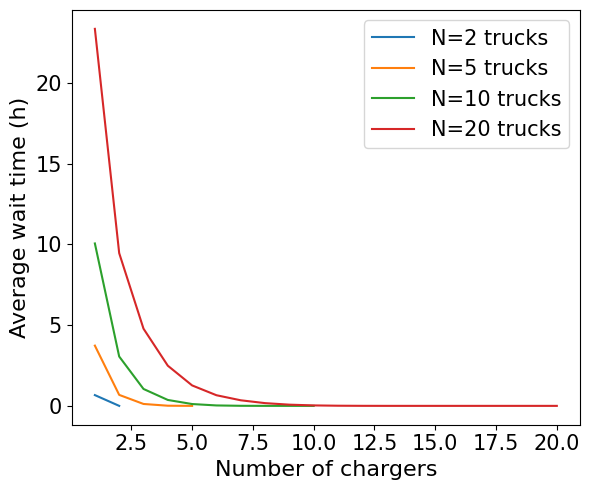

In [4]:
# Make a plot of the average wait time as a function of N and C
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

CHARGING_TIME=4.    # Charging time, in hours

def p_X_at_A(N, X):
    return scipy.special.binom(N-1, X) * (1./3.)**X * (2./3.)**(N-1-X)

# Average wait time for Q <= C
def mu_lt_C(Q, C):
    
    def P_C(t):
        return (1-t/CHARGING_TIME)**C
    
    mu_0, res = quad(P_C, 0, CHARGING_TIME)
    mu_last = mu_0
    mu_Q = mu_0
    for i in range(1, Q+1):  
        def P_C_minus_i(t):
            return (1-t/CHARGING_TIME)**(C-i)
        mu_Q_int, res = quad(P_C_minus_i, mu_last, CHARGING_TIME)
        mu_Q = mu_last + mu_Q_int
        mu_last = mu_Q 
    return mu_Q

# Average wait time in general (Q can be > C)
def mu(Q, C):
    if Q < C:
        return mu_lt_C(Q,C)
    else:
        F = np.floor(Q/C)
        R = int(Q - F*C)
        return mu_lt_C(R, C) + CHARGING_TIME*F

Ns = [2, 5, 10, 20]

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel('Number of chargers', fontsize=16)
ax.set_ylabel('Average wait time (h)', fontsize=16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


i=0
j=0
for N in Ns:
    Cs = []
    t_waits = []
    for C in np.arange(1, N+1):
        Cs.append(C)
        Xs = np.arange(C, N+1)
        t_wait = 0
        for X in Xs:
            Q = X-C
            t_wait += p_X_at_A(N, X) * mu(Q, C)
        t_waits.append(t_wait)
    ax.plot(Cs, t_waits, label='N=%d trucks'%N)
    i+=1
    if i==5: 
        i=0
        j+=1
    plt.tight_layout()
    
ax.legend(fontsize=15)


4. Now let's apply a constraint that the average wait time be below some maximum threshold (say 1h). For a given number of trucks, find the miminum required charger to truck ratio.

N: 1, min_charger_ratio: 1.000000
N: 2, min_charger_ratio: 0.500000
N: 3, min_charger_ratio: 0.666667
N: 4, min_charger_ratio: 0.500000
N: 5, min_charger_ratio: 0.400000
N: 6, min_charger_ratio: 0.500000
N: 7, min_charger_ratio: 0.428571
N: 8, min_charger_ratio: 0.375000
N: 9, min_charger_ratio: 0.333333
N: 10, min_charger_ratio: 0.400000
N: 11, min_charger_ratio: 0.363636
N: 12, min_charger_ratio: 0.333333
N: 13, min_charger_ratio: 0.307692
N: 14, min_charger_ratio: 0.285714
N: 15, min_charger_ratio: 0.333333
N: 16, min_charger_ratio: 0.312500
N: 17, min_charger_ratio: 0.294118
N: 18, min_charger_ratio: 0.277778
N: 19, min_charger_ratio: 0.315789
N: 20, min_charger_ratio: 0.300000
N: 21, min_charger_ratio: 0.285714
N: 22, min_charger_ratio: 0.272727
N: 23, min_charger_ratio: 0.304348
N: 24, min_charger_ratio: 0.291667
N: 25, min_charger_ratio: 0.280000
N: 26, min_charger_ratio: 0.269231
N: 27, min_charger_ratio: 0.259259
N: 28, min_charger_ratio: 0.285714
N: 29, min_charger_ratio: 0.2

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

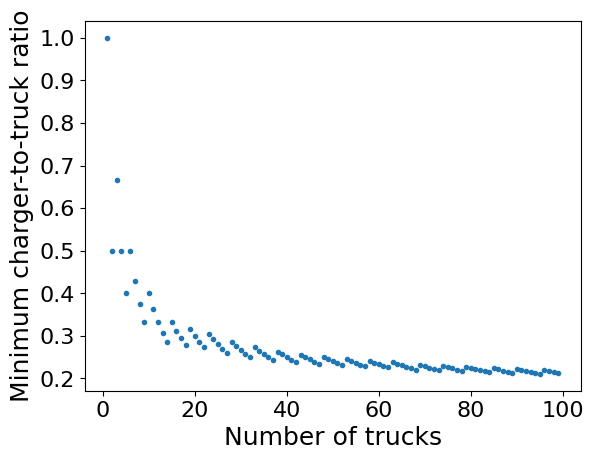

In [51]:
Ns = np.arange(1,100)
MAX_WAIT_TIME=1  # Max allowable wait time, in hours

def average_wait_time(N, C):
    Xs = np.arange(C, N+1)
    t_wait = 0
    for X in Xs:
        Q = X-C
        t_wait += p_X_at_A(N, X) * mu(Q, C)
        
    return t_wait

min_charger_ratios = np.ones(len(Ns))
i_N=0
for N in Ns:
    Cs = np.arange(1,N)
    for C in Cs:
        av_wait = average_wait_time(N, C)
        if av_wait < MAX_WAIT_TIME:
            min_charger_ratios[i_N] = 1.*C/(1.*N)
            break
    i_N += 1
    
# Make a plot of the minimum charger ratio as a function of N
plt.plot(Ns, min_charger_ratios, '.')
plt.xlabel('Number of trucks', fontsize=18)
plt.ylabel('Minimum charger-to-truck ratio', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

4. Now suppose we extend the distance between the warehouses to 400 miles such that they require a quick charger in between. The quick charger has a power of 800kW, and an associated charging time of 30 minutes. 

Assuming that we have a high enough charger-to-truck ratio at the warehouses to keep the wait times at the warehouses negligibly small (i.e. below 1h), what is the minimum charger to truck ratio at the quick charger needed to keep the wait time at the quick charger below 30 minutes?

We now have 

$$P(\text{X at quick charger}) = P(\text{X at QC}) = \binom{N-1}{X}\Big(\frac{1}{17}\Big)^X\Big(\frac{16}{17}\Big)^{N-1-X}$$

All the other math remains the same, with a charging time of 30 minutes. 

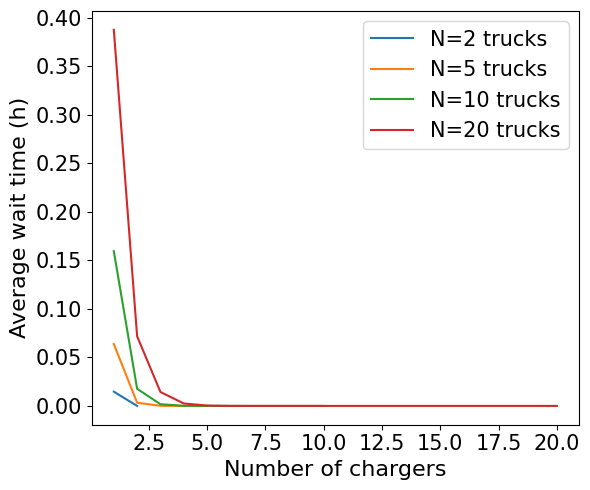

In [5]:
# Make a plot of the average wait time as a function of N and C
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

CHARGING_TIME=0.5    # Charging time, in hours

def p_X_at_A(N, X):
    return scipy.special.binom(N-1, X) * (1./17.)**X * (16./17.)**(N-1-X)

# Average wait time for Q <= C
def mu_lt_C(Q, C):
    
    def P_C(t):
        return (1-t/CHARGING_TIME)**C
    
    mu_0, res = quad(P_C, 0, CHARGING_TIME)
    mu_last = mu_0
    mu_Q = mu_0
    for i in range(1, Q+1):  
        def P_C_minus_i(t):
            return (1-t/CHARGING_TIME)**(C-i)
        mu_Q_int, res = quad(P_C_minus_i, mu_last, CHARGING_TIME)
        mu_Q = mu_last + mu_Q_int
        mu_last = mu_Q 
    return mu_Q

# Average wait time in general (Q can be > C)
def mu(Q, C):
    if Q < C:
        return mu_lt_C(Q,C)
    else:
        F = np.floor(Q/C)
        R = int(Q - F*C)
        return mu_lt_C(R, C) + CHARGING_TIME*F

Ns = [2, 5, 10, 20]

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel('Number of chargers', fontsize=16)
ax.set_ylabel('Average wait time (h)', fontsize=16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


i=0
j=0
for N in Ns:
    Cs = []
    t_waits = []
    for C in np.arange(1, N+1):
        Cs.append(C)
        Xs = np.arange(C, N+1)
        t_wait = 0
        for X in Xs:
            Q = X-C
            t_wait += p_X_at_A(N, X) * mu(Q, C)
        t_waits.append(t_wait)
    ax.plot(Cs, t_waits, label='N=%d trucks'%N)
    i+=1
    if i==5: 
        i=0
        j+=1
    plt.tight_layout()
    
ax.legend(fontsize=15)


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

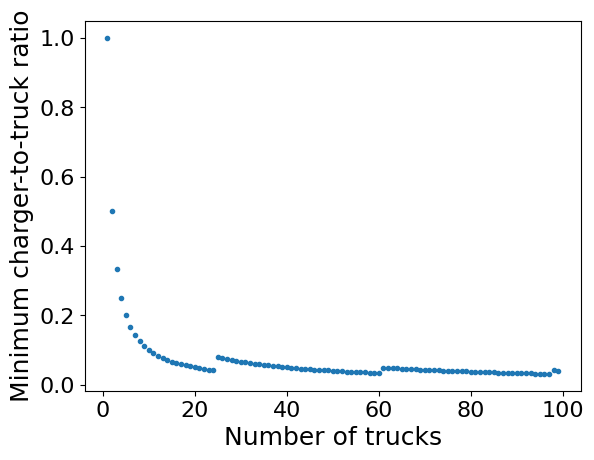

In [7]:
Ns = np.arange(1,100)
MAX_WAIT_TIME=0.5  # Max allowable wait time, in hours

def average_wait_time(N, C):
    Xs = np.arange(C, N+1)
    t_wait = 0
    for X in Xs:
        Q = X-C
        t_wait += p_X_at_A(N, X) * mu(Q, C)
        
    return t_wait

min_charger_ratios = np.ones(len(Ns))
i_N=0
for N in Ns:
    Cs = np.arange(1,N)
    for C in Cs:
        av_wait = average_wait_time(N, C)
        if av_wait < MAX_WAIT_TIME:
            min_charger_ratios[i_N] = 1.*C/(1.*N)
            break
    i_N += 1

# for i_N in np.arange(len(Ns)):
#     print('N: %d, min ratio: %f'%(Ns[i_N], min_charger_ratios[i_N]))
    
# Make a plot of the minimum charger ratio as a function of N
plt.plot(Ns, min_charger_ratios, '.')
plt.xlabel('Number of trucks', fontsize=18)
plt.ylabel('Minimum charger-to-truck ratio', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

5. What are the potential % savings for two fleets of N trucks sharing infrastructure costs?

If both fleets want to keep wait times at warehouses below $t_\text{wait}$, the % savings in charging infrastructure costs are given by:

$$\text{% savings} = 100\%\cdot\Big(1-\frac{(C/N)_\text{2N, t$_\text{wait}$<1h}}{(C/N)_\text{N, t$_\text{wait}$<1h}}\Big)$$

Conversely, we can also consider fixing the charger-to-truck ratio to its value with each fleet kept separate, and assess how much savings we get in terms of reduced wait times at chargers from sharing the infrastructure. 

In [72]:
# First do this for the cases of warehouse charging

def p_X_at_A(N, X, p_at_charger = 1./3.):
    return scipy.special.binom(N-1, X) * (p_at_charger)**X * (1.-p_at_charger)**(N-1-X)

# Average wait time for Q <= C
def mu_lt_C(Q, C, charging_time=4):
    
    def P_C(t):
        return (1-t/charging_time)**C
    
    mu_0, res = quad(P_C, 0, charging_time)
    mu_last = mu_0
    mu_Q = mu_0
    for i in range(1, Q+1):  
        def P_C_minus_i(t):
            return (1-t/charging_time)**(C-i)
        mu_Q_int, res = quad(P_C_minus_i, mu_last, charging_time)
        mu_Q = mu_last + mu_Q_int
        mu_last = mu_Q 
    return mu_Q

# Average wait time in general (Q can be > C)
def mu(Q, C, charging_time=4):
    if Q < C:
        return mu_lt_C(Q,C, charging_time)
    else:
        F = np.floor(Q/C)
        R = int(Q - F*C)
        return mu_lt_C(R, C, charging_time) + charging_time*F

def average_wait_time(N, C, charging_time=4, p_at_charger=1./3.):
    Xs = np.arange(C, N+1)
    t_wait = 0
    for X in Xs:
        Q = X-C
        t_wait += p_X_at_A(N, X, p_at_charger) * mu(Q, C, charging_time)
        
    return t_wait

def get_min_charger_ratio(N, charging_time, max_wait_time=1., p_at_charger=1./.3):
    Cs = np.arange(1,N)
    min_charger_ratio=1.
    for C in Cs:
        av_wait = average_wait_time(N, C, charging_time, p_at_charger)
        if av_wait < max_wait_time:
            min_charger_ratio = 1.*C/(1.*N)
            break
    return min_charger_ratio

Ns = [1,4,20,50,100,200]

charging_time=4.
max_wait_time=1.
p_at_charger=1./3.

for N in Ns:
    ratio_N = get_min_charger_ratio(N, charging_time, max_wait_time, p_at_charger) 
    ratio_2N = get_min_charger_ratio(2*N, charging_time, max_wait_time, p_at_charger)
    percent_charger_savings = 100. * (1. - 1.*ratio_2N / (1.*ratio_N))
    #print('N: %d, min charger ratio: %f. N: %d, min charger ratio: %f'%(N, ratio_N, 2*N, ratio_2N))
    print('%% charger savings for N=%d with %.1fh charging, max wait of %.1fh and %.2f probability to be at charger: %.3f%%. C_N: %d, C_2N: %d. C_N/N: %f, C_2N/2N: %f'%(N, charging_time, max_wait_time, p_at_charger, percent_charger_savings, ratio_N*N, ratio_2N*2*N, ratio_N, ratio_2N))

print('\n\n')

Ns = [1,4,100,160,200,400]

charging_time=0.5
max_wait_time=0.5
p_at_charger=1./17.
for N in Ns:
    ratio_N = get_min_charger_ratio(N, charging_time, max_wait_time, p_at_charger) 
    ratio_2N = get_min_charger_ratio(2*N, charging_time, max_wait_time, p_at_charger)
    percent_charger_savings = 100. * (1. - 1.*ratio_2N / (1.*ratio_N))
    print('%% charger savings for N=%d with %.1fh charging, max wait of %.1fh and %.2f probability to be at charger: %.3f%%. C_N: %d, C_2N: %d. C_N/N: %f, C_2N/2N: %f'%(N, charging_time, max_wait_time, p_at_charger, percent_charger_savings, ratio_N*N, ratio_2N*2*N, ratio_N, ratio_2N))

% charger savings for N=1 with 0.5h charging, max wait of 0.5h and 0.06 probability to be at charger: 50.000%. C_N: 1, C_2N: 1. C_N/N: 1.000000, C_2N/2N: 0.500000
% charger savings for N=4 with 0.5h charging, max wait of 0.5h and 0.06 probability to be at charger: 50.000%. C_N: 1, C_2N: 1. C_N/N: 0.250000, C_2N/2N: 0.125000
% charger savings for N=100 with 0.5h charging, max wait of 0.5h and 0.06 probability to be at charger: 25.000%. C_N: 4, C_2N: 6. C_N/N: 0.040000, C_2N/2N: 0.030000
% charger savings for N=160 with 0.5h charging, max wait of 0.5h and 0.06 probability to be at charger: 10.000%. C_N: 5, C_2N: 9. C_N/N: 0.031250, C_2N/2N: 0.028125
% charger savings for N=200 with 0.5h charging, max wait of 0.5h and 0.06 probability to be at charger: 8.333%. C_N: 6, C_2N: 11. C_N/N: 0.030000, C_2N/2N: 0.027500
% charger savings for N=400 with 0.5h charging, max wait of 0.5h and 0.06 probability to be at charger: 4.545%. C_N: 11, C_2N: 21. C_N/N: 0.027500, C_2N/2N: 0.026250
